In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from utils import modeling_utils, data_processing

%reload_ext autoreload
%autoreload 2

# Modeling
- My idea is to build a model that will allow to explain the probability of victory given some of the collected post game statistics.

In [2]:
# tournaments to evaluate
major_regions = ['LPL', 'LCK', 'LEC', 'LCS', 'MSI', 'WCS', 'NA LCS', 'EU LCS', 'KeSPA']
# droping columns that i find no use for at least for now
drop_irrelevant = [
    'gameid', 'datacompleteness', 'url', 'split', 'playoffs', 
    'date', 'game', 'patch', 'participantid', 'position', 
    'playerid', 'teamname', 'teamid', 'champion', 'ban1', 
    'ban2', 'ban3', 'ban4', 'ban5', ]

# problematic columns, i think some of them can be added from column 'pos' == 'team' 
# but still there is problem with relevant LPL statistics 
drop_large_nulls = [
    'firstdragon', 'dragons', 'opp_dragons', 'elementaldrakes', 
    'opp_elementaldrakes', 'infernals', 'mountains', 'clouds', 
    'oceans', 'chemtechs', 'hextechs', 'dragons (type unknown)', 
    'elders', 'opp_elders', 'firstherald', 'heralds', 
    'opp_heralds', 'firstbaron', 'inhibitors', 'opp_inhibitors',
    'firsttower', 'towers', 'opp_towers', 'firstmidtower', 'firsttothreetowers', 'turretplates', 'opp_turretplates', 'gspd']

# interesting game start to evaluate
game_stats = ['kills', 'deaths', 'assists', 'dpm', 'damageshare', 'wardsplaced', 'wardskilled', 'minionkills', 'monsterkillsownjungle', 'monsterkillsenemyjungle']

df_init = data_processing.prepare_data_leesin(major_regions, drop_irrelevant, drop_large_nulls)

/home/quak/development/lol_stats/src/utils/data_processing.py:6: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + file_name)


- Many features are susceptible to time, with more time we care score more kills etc, because of this I have decided to preprocess the data by calculate statistics such as kills per minute etc. which can be easily evaluated during the ongoing game
- kill_participation - is a ratio of combined kills and assists to total team kills, how impactful a player is
- death_ratio - number of player deaths to the total team death

In [3]:
df = (
    df_init
    .assign(time_min=lambda x: round(x['gamelength']/60, 0))
    .assign(
        kills_pm=lambda x: x['kills'] / x['time_min'],
        deaths_pm=lambda x: x['deaths'] / x['time_min'],
        assists_pm=lambda x: x['assists'] / x['time_min'],
        kill_participation=lambda x: np.where(x['teamkills'], (x['kills'] + x['assists']) / x['teamkills'], 0),
        death_ratio=lambda x: np.where(x['teamdeaths'], x['deaths'] / x['teamdeaths'], 0),
    )
)

In [4]:
df[
    ['kills_pm', 'deaths_pm', 'assists_pm', 'kill_participation', 'death_ratio', 'teamkills', 'teamdeaths', 'kills', 'deaths', 'assists']
].isna().sum().sort_values()

kills_pm              0
deaths_pm             0
assists_pm            0
kill_participation    0
death_ratio           0
teamkills             0
teamdeaths            0
kills                 0
deaths                0
assists               0
dtype: int64

# Modeling logistic regression

In [6]:
target = ['result']

bin_features = ['time_min']
ohe_features = []#['side']
std_features = [] #['dpm', 'damageshare']
norm_features = ['kills_pm', 'deaths_pm', 'assists_pm', 
                 'kill_participation', 'death_ratio']

preprocessor = modeling_utils.create_preprocessor(bin_features, ohe_features, std_features, norm_features)

In [7]:
from sklearn.model_selection import train_test_split
X, y = df.drop(columns=target), df[target].to_numpy().ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

model_pipe = Pipeline([
    ('data_prep', preprocessor), 
    ('model', LogisticRegression(max_iter=1000))
])
param_grid = {
    'model__C': np.linspace(0.01, 3, 10)
}

search = (
    GridSearchCV(model_pipe, param_grid, scoring='roc_auc', n_jobs=6)
    .fit(X_train, y_train)
)

print(f'Best auc score: {search.best_score_}')

Best auc score: 0.9808911790323567


## Evaluation

              precision    recall  f1-score   support

        Loss       0.94      0.92      0.93       462
         Win       0.93      0.95      0.94       458

    accuracy                           0.93       920
   macro avg       0.93      0.93      0.93       920
weighted avg       0.93      0.93      0.93       920



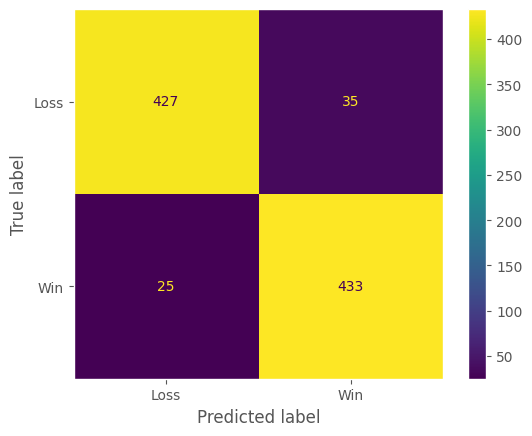

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

model = search.best_estimator_
y_pred = model.predict(X_test)

pred_lab = ['Loss', 'Win']
print(classification_report(y_test, y_pred, target_names=pred_lab))


cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pred_lab)
disp.plot(), plt.grid(False)
plt.show()

Best threshold: 0.416, fpr: 0.091, tpr: 0.969


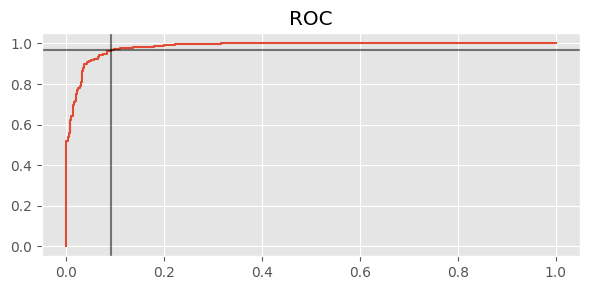

In [10]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1], pos_label=1)
gmeans = np.sqrt(tpr * (1 - fpr))
idx = np.argmax(gmeans)
print(f'Best threshold: {round(thresholds[idx], 3)}, fpr: {round(fpr[idx], 3)}, tpr: {round(tpr[idx], 3)}')

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(fpr, tpr), ax.axvline(fpr[idx], color='k', alpha=.5), ax.axhline(tpr[idx], color='k', alpha=.5)
ax.set_title('ROC')
fig.tight_layout()

### Values of coefficients

In [11]:
x = {x: round(y, 3) for x, y in zip(model[0].get_feature_names_out(), model[-1].coef_[0])}
x['intercept'] = model[-1].intercept_
coefs = pd.DataFrame(x).T
coefs.columns = ['coef']
coefs['value'] = abs(coefs['coef'])
coefs['sign'] = np.where(coefs['coef']>= 0, 1,0)


coefs.sort_values('value', ascending=False).drop(columns='value')

,coef,sign
normalizing__deaths_pm,-18.225000,0
normalizing__assists_pm,14.167000,1
normalizing__death_ratio,7.301000,1
normalizing__kills_pm,6.878000,1
normalizing__kill_participation,-3.435000,0
intercept,-0.340197,0
bining__time_min,-0.045000,0


I feel like we should drop kda_pm stats